In [1]:
# from google.colab import drive
# drive.mount("/content/drive", force_remount=True)

In [27]:
# ! python -m spacy download en

In [17]:
import pandas as pd
import numpy as np
import os
import re
import zipfile
import requests
from bs4 import BeautifulSoup
from collections import Counter
import itertools

import spacy
from spacy.tokenizer import Tokenizer
import gensim as gen
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
AMBIGUOUS_WORDS_URL = 'https://muse.dillfrog.com/lists/ambiguous'

Load Dataset:

In [19]:
df =pd.read_pickle('eda_reddit_jokes.pkl')[:5000]

In [20]:
df.head()

,joke,score
0,I hate how you cant even say black paint anymo...,1
1,"Brian raises his hand and says, “He’s in Heave...",1
2,I walked into a PETA adoption center and the r...,1
3,Remember when you were a kid and when you crie...,15
4,"My boss said to me, ""you're the worst train dr...",3


Load Gensim word embedddings (Google news negative) - Need to check if there's a better embedding to use

In [21]:
# model_embeddings = gen.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary=True)

In [28]:
nlp = spacy.load('en')
def en_tokenize(string):
    return nlp(string)

Add ambiguous words counter features:

In [29]:
def get_ambiguous_words():
  res = requests.get(AMBIGUOUS_WORDS_URL)
  page_soup = BeautifulSoup(res.content)
  a_tags = page_soup.find_all('a', href=re.compile(r'.*/meaning/word/*'))
  ambiguous_words = [word.text for word in a_tags]
  return ambiguous_words

In [30]:
ambiguous_words = get_ambiguous_words()
df['ambiguous_words'] = df['joke'].apply(lambda x: sum([str(w) in ambiguous_words for w in x]))
df['ambiguous_words'].head()

0    4
1    7
2    3
3    2
4    1
Name: ambiguous_words, dtype: int64

Repetition

In [31]:
spacy_col = df['joke'].apply(en_tokenize)

In [32]:
token_pos = spacy_col.apply(lambda x: [(elm.text, elm.pos_) for elm in x])

In [33]:
from gensim.models import Word2Vec
from nltk.corpus import brown
nltk.download('brown')
b = Word2Vec(brown.sents())

def find_best_similarity(string):
    """ find the max similarity between two words """
    # unique words:
    word_list = list(set([word_pos[0] for word_pos in string if word_pos[1] != "PROPN"]))
    all_combi = list(itertools.combinations(word_list, 2))

    max_similarity = 0
    for pairs in all_combi:
        try:
            temp_similatity = b.similarity(pairs[0], pairs[1])
            if temp_similatity > max_similarity:
                max_similarity = temp_similatity
        except:
            pass # don't found the word in word2vec
    return max_similarity

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


In [34]:
df['best_score_similarity_words'] = token_pos.apply(find_best_similarity)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  from ipykernel import kernelapp as app


In [35]:
df['best_score_similarity_words'].head()

0    0.917978
1    0.950604
2    0.939134
3    0.919648
4    0.915605
Name: best_score_similarity_words, dtype: float64

Antoym

In [36]:
list_of_antonyms=[]
from nltk.corpus import wordnet as wn
for i in wn.all_synsets():
    if i.pos() in ['a', 's']: 
        for j in i.lemmas(): 
            if j.antonyms(): 
                (j.name(), j.antonyms()[0].name()) and list_of_antonyms.append((j.name(), j.antonyms()[0].name()))
dict_antonyms = dict((y, x) for x, y in list_of_antonyms)

def find_antonyms(tokens_poss):
    """ count how many antonyms in sentence """
    word_list = [word_pos[0] for word_pos in tokens_poss]
    count = 0
    for word in word_list:
        try:
            if word in dict_antonyms:
                if dict_antonyms[word] in word_list:
                    count += 1
        except Exception:
            pass # don't found in dict
    return count


In [37]:
df['antonyms'] = token_pos.apply(find_antonyms)

In [38]:
df['antonyms'].head()

0    0
1    0
2    0
3    0
4    0
Name: antonyms, dtype: int64

Longest word

In [39]:
def len_longest_word(tokens_poss):
    """ check the length of the longest word """
    word_len_list = [(word_pos[0], len(word_pos[0]))  for word_pos in tokens_poss]
    word_len_list = sorted(word_len_list, key=lambda x: x[1])

    return word_len_list[-1][1]

In [40]:
df['longest_word'] = token_pos.apply(len_longest_word)

In [41]:
df['longest_word'].head()

0     7
1     9
2    12
3     8
4     8
Name: longest_word, dtype: int64

How many speical chars

In [42]:
def count_speical_chars(tokens_poss):
    """ how many speical chars in string """
    bin_isalphanumberic_list = [not word_pos[0].isalnum() for word_pos in tokens_poss]

    return np.sum(bin_isalphanumberic_list)

In [43]:
df['speical_chars'] = token_pos.apply(count_speical_chars)

In [44]:
df['speical_chars'].head()

0     4
1    44
2     5
3     8
4    14
Name: speical_chars, dtype: int64

Add object counter features:

In [45]:
df['joke_tokenized'] = df['joke'].apply(nlp)

In [46]:
def add_object_count_cols(df,tokenized_col):
  df['temp'] = df[tokenized_col].apply(lambda x: [ent.label_ for ent in x.ents])
  mlb = MultiLabelBinarizer()
  mlb.fit(df['temp'])
  df = df.join(pd.DataFrame(mlb.transform(df['temp']),
                            columns=mlb.classes_,
                            index=df.index))
  del df['temp']
  return df


In [47]:
df = add_object_count_cols(df,'joke_tokenized')

In [48]:
df.shape

(5000, 26)

Add Part-of-Speech features:

In [49]:
def add_pos_count_cols(df,tokenized_col):
  df['temp'] = df[tokenized_col].apply(lambda x: [ent.pos_ for ent in x])
  mlb = MultiLabelBinarizer()
  mlb.fit(df['temp'])
  df = df.join(pd.DataFrame(mlb.transform(df['temp']),
                            columns=mlb.classes_,
                            index=df.index))
  del df['temp']
  return df

In [50]:
df = add_pos_count_cols(df,'joke_tokenized')

In [51]:
df.shape

(5000, 44)

Text cleaning:

In [52]:
def replace_non_eng_punct(txt):
    return re.sub(r'/[^a-zA-Z0-9\s,.?!]/','*',txt).strip()

In [53]:
def replace_escape(txt):
    updated_txt = re.sub(r'\n|\t|&amp;',' ',txt)
    return updated_txt.strip()

In [54]:
def remove_multi_spaces(txt):
    return re.sub(' +', ' ',txt)

In [55]:
def preprocess_text(document):
  #         # Remove all the special characters
  document = re.sub(r'\W', ' ', str(document))

  #         # remove all single characters
  document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

  #         # Remove single characters from the start
  document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

  # Substituting multiple spaces with single space
  document = re.sub(r'\s+', ' ', document, flags=re.I)

  # Removing prefixed 'b'
  document = re.sub(r'^b\s+', '', document)

  # Converting to Lowercase
  document = document.lower()

  return document

In [56]:
df['joke_text_processed'] = df['joke'].apply(replace_non_eng_punct).apply(remove_multi_spaces).apply(replace_escape)

In [57]:
df['joke_text_processed'] = df['joke_text_processed'].apply(preprocess_text)

In [58]:
df['joke_processed_tokenized'] = df['joke_text_processed'].apply(nlp)

In [59]:
df['joke_processed_tokenized'][55]

did you hear about leatherface jewish cousin he was also serial killer he liked to dig up the corpses of women and use their skin to furnish his house after the police arrested him they discovered whole morbid collection of objects he had belt made out of ears lampshade made from stitched together faces they even found labia menora 

Lemmatization:

In [60]:
stemmer = WordNetLemmatizer()
stop_words = stopwords.words('english')
lemmatize_remove_stop_words = lambda x: nlp(' '.join([stemmer.lemmatize(str(word)) for word in x if str(word) not in stop_words]))
lemmatize_remove_stop_words_str = lambda x: ' '.join([stemmer.lemmatize(str(word)) for word in x if str(word) not in stop_words])

In [61]:
df['joke_processed_tokenized_stemmed'] = df['joke_processed_tokenized'].apply(lemmatize_remove_stop_words)
df['joke_processed_tokenized_stemmed_str'] = df['joke_processed_tokenized'].apply(lemmatize_remove_stop_words_str)

Build embedding features:

In [116]:
vocab_size = 3000

In [71]:
def count_common(pd_series):
    cnt = Counter()
    for s in list(pd_series):
        for t in s:
            cnt[t] += 1
    return set([i[0] for i in cnt.most_common(vocab_size)])

In [72]:
common_words = count_common(df['joke_processed_tokenized_stemmed'])

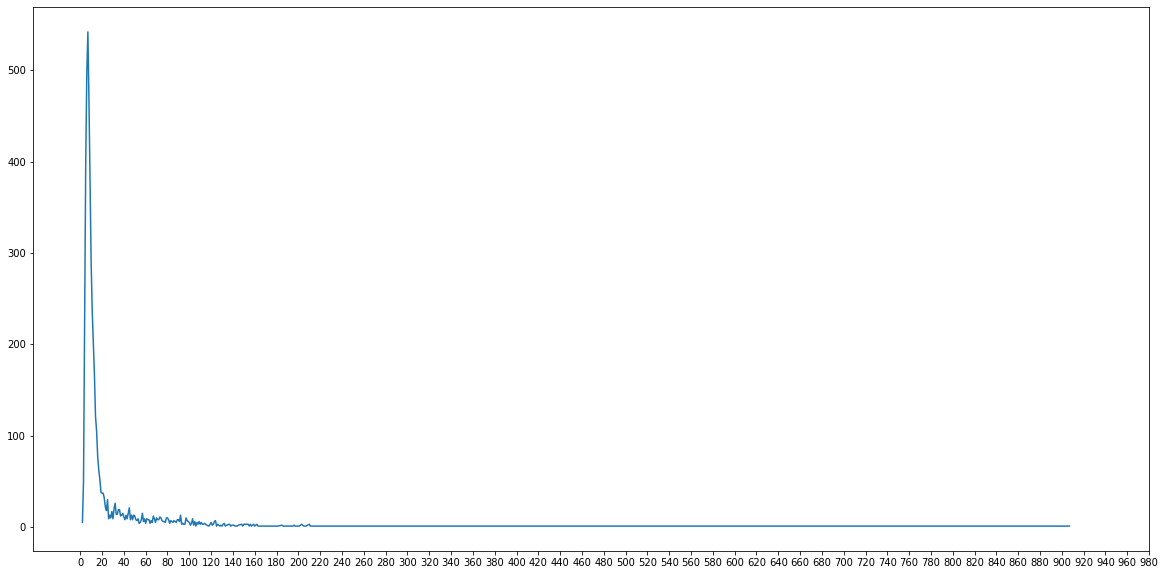

In [105]:
f = plt.figure(figsize=(20,10))
ax = sns.lineplot(data = df['joke_processed_tokenized_stemmed'].apply(len).value_counts())
ax.set_xticks(np.arange(0,1000,20));

In [106]:
df = df[df['joke_processed_tokenized_stemmed'].apply(len) < 21]

In [107]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = 20
joke_tokenizer = Tokenizer(filters='')
joke_tokenizer.fit_on_texts(df['joke_processed_tokenized_stemmed_str'])
joke_tensor = joke_tokenizer.texts_to_sequences(df['joke_processed_tokenized_stemmed_str'])
joke_tensor_seq = pad_sequences(joke_tensor, maxlen=maxlen, padding='post', value=0)

In [122]:
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, TimeDistributed
from keras.utils import to_categorical
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential

embedding_dim = 200

In [129]:
joke_embeddings.shape

TensorShape([Dimension(None), Dimension(20), Dimension(200)])

In [131]:
tokens = Input(shape=(maxlen,))
joke_embeddings = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(tokens)
model = Model(input = joke_tensor_seq, output = joke_embeddings)

# model = Sequential()
# model.add(Embedding(vocab_size, embedding_dim, input_length=maxlengt))

TypeError: ('Keyword argument not understood:', 'input')

In [124]:
model = Model(joke_tensor_seq, joke_embeddings)
model.compile(loss='rmse', optimizer='adam', metrics=['rmse'])
model.fit(joke_tensor_seq, batch_size=64, epochs=100,
          validation_split = 0.2)
model.predict([en_tensor_value,fr_tensor_pred])[:,3,:][0].argmax()

TypeError: unhashable type: 'numpy.ndarray'

In [113]:
df.loc[0,'joke']

'I hate how you cant even say black paint anymore. Now I have to say "Leroy can you please paint the fence?"'

In [109]:
joke_tensor_seq[0]

array([  90,  605,  208,  148,    1,   64,  680,  322,    1, 3618,  368,
        680,  767,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
def get_sentence_embeddings(sentence):
  embedding = np.zeros((len(sentence),300))
  for ind,token in enumerate(sentence):
    if str(token) in model_embeddings.vocab.keys():
      embedding[ind] = model_embeddings[str(token)]
    else:
      pass
  embedding = embedding.mean(axis = 0)
  return embedding

def add_pos_count_cols(df,tokenized_col):
  df['temp'] = df[tokenized_col].apply(lambda x: [ent.pos_ for ent in x])
  mlb = MultiLabelBinarizer()
  mlb.fit(df['temp'])
  df = df.join(pd.DataFrame(mlb.transform(df['temp']),
                            columns=mlb.classes_,
                            index=df.index))

In [ ]:
df['joke_embbedings'] = df['joke_processed_tokenized_stemmed'].apply(get_sentence_embeddings)

In [ ]:
classes = [f'sentence_vec_{i}' for i in range(300)]
df = df.merge(pd.DataFrame(df['joke_embbedings'].tolist(), columns = classes, index= df['joke_embbedings'].index),
                           how='left',left_index=True, right_index=True)

In [92]:
df.shape

(5000, 348)

Build total words / total chars features:

In [ ]:
df['total_words'] = df['joke_tokenized'].apply(len)
df['total_chars'] = df['joke'].apply(len)

Split to train/test set:

In [ ]:
target = 'score'
X = df[df.columns[df.columns!=target]]
y = df[target]

In [ ]:
## Use validation set
# Split earlier to avoid leakage
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Add CountVectorizer features:

In [ ]:
vectorizer = CountVectorizer(input='content', decode_error='strict', lowercase=True, stop_words='english', ngram_range=(1, 2), 
                max_features=1000, binary=True)

In [ ]:
vectorizer.fit(X_train['joke_processed_tokenized_stemmed_str'])
count_vec_train = vectorizer.transform(X_train['joke_processed_tokenized_stemmed_str']).toarray()
count_vec_test = vectorizer.transform(X_test['joke_processed_tokenized_stemmed_str']).toarray()

In [ ]:
X_train = X_train.merge(pd.DataFrame(count_vec_train,columns=vectorizer.vocabulary_),how='left',left_index=True,right_index=True)
X_test = X_test.merge(pd.DataFrame(count_vec_test,columns=vectorizer.vocabulary_),how='left',left_index=True,right_index=True)

In [112]:
X_train.shape

(4000, 1349)

In [113]:
X_test.shape

(1000, 1349)

Dump output:

In [ ]:
pd.to_pickle(X_train, "X_train.pkl")
pd.to_pickle(X_test, "X_test.pkl")
pd.to_pickle(y_train, "y_train.pkl")
pd.to_pickle(y_test, "y_test.pkl")